In [1]:
using Revise
# using InvariantDA
using LinearAlgebra
using OrdinaryDiffEq
using Trixi

In [2]:
using CairoMakie
using LaTeXStrings

[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
[ Info: Precompiling TrixiMakieExt [585a13d5-dd36-5759-a896-4d6603caa5ba]
[ Info: Precompiling GeometryBasicsExt [b238bd29-021f-5edc-8b0e-16b9cda5f63a]
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


In [3]:
# The same setup as tree_1d_dgsem/elixir_advection_basic.jl
# to verify the StructuredMesh implementation against TreeMesh

###############################################################################
# semidiscretization of the linear advection equation

equations = LinearScalarAdvectionEquation1D(1.0)

# Use N Gauss-Lobatto points per element 
N = 5 # number of points 
basis = LobattoLegendreBasis(N) # initiate basis (points and weights) 

VolumeIntegralWeakForm(

solver = DGSEM(basis, surface_flux, volume_integral)

boundary_conditions=boundary_condition_periodic

coordinates_min = (-1.0,) # minimum coordinate
coordinates_max = (1.0,) # maximum coordinate

# Create curved mesh with 16 cells
cells_per_dimension = (64,) 
mesh = StructuredMesh(cells_per_dimension, coordinates_min, coordinates_max)

#mesh = TreeMesh(coordinates_min, coordinates_max,
#                initial_refinement_level = 6,
#                n_cells_max = 10_000,
#                periodicity = true)

# A semidiscretization collects data structures and functions for the spatial discretization
semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition_convergence_test,
                                    boundary_conditions=boundary_condition_periodic, solver)

###############################################################################
# ODE solvers, callbacks etc.

# Create ODE problem with time span from 0.0 to 1.0
tspan = (0.0, 1.0)
ode = semidiscretize(semi, tspan);

# At the beginning of the main loop, the SummaryCallback prints a summary of the simulation setup
# and resets the timers
summary_callback = SummaryCallback()

# The AnalysisCallback allows to analyse the solution in regular intervals and prints the results
analysis_callback = AnalysisCallback(semi, interval = 100)

# The SaveSolutionCallback allows to save the solution to a file in regular intervals
save_solution = SaveSolutionCallback(interval = 100,
                                     solution_variables = cons2prim)

# The StepsizeCallback handles the re-calculation of the maximum Δt after each time step
stepsize_callback = StepsizeCallback(cfl = 0.85)

# Create a CallbackSet to collect all callbacks such that they can be passed to the ODE solver
callbacks = CallbackSet(summary_callback)#, analysis_callback, save_solution,
#                         stepsize_callback);

CallbackSet{Tuple{}, Tuple{DiscreteCallback{typeof(Trixi.summary_callback), typeof(Trixi.summary_callback), Trixi.var"#initialize#1389"{Bool}, typeof(SciMLBase.FINALIZE_DEFAULT)}}}((), (SummaryCallback,))

In [79]:
###############################################################################
# run the simulation

# OrdinaryDiffEq's `solve` method evolves the solution in time and executes the passed callbacks
@time sol = solve(ode, SSPRK43(), 
            dt = 42, # solve needs some value here but it will be overwritten by the stepsize_callback
            save_everystep = true, callback = callbacks);
summary_callback() # print the timer summary


████████╗██████╗ ██╗██╗  ██╗██╗
╚══██╔══╝██╔══██╗██║╚██╗██╔╝██║
   ██║   ██████╔╝██║ ╚███╔╝ ██║
   ██║   ██╔══██╗██║ ██╔██╗ ██║
   ██║   ██║  ██║██║██╔╝ ██╗██║
   ╚═╝   ╚═╝  ╚═╝╚═╝╚═╝  ╚═╝╚═╝

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… StructuredMesh{1, Float64}                                       │
│ equations: …………………………………………………… InviscidBurgersEquation1D                                        │
│ initial condition: ……………………………… initial_condition_convergence_test                               │
│ boundary conditions: ………………………… Trixi.BoundaryConditionPeriodic                                  

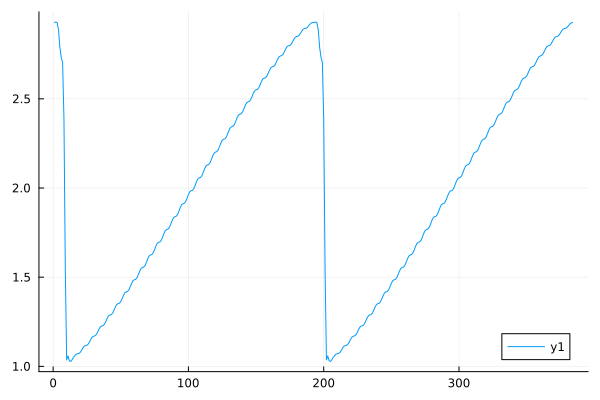

In [80]:
#sol.t[100]
Plots.plot(sol[200])

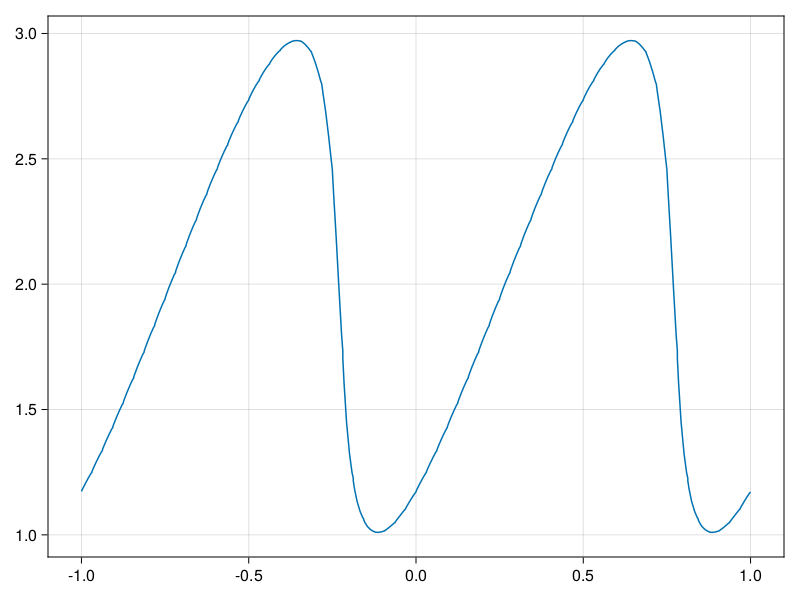

In [81]:
lines(vec(x), vec(sol.u[100]))

In [82]:
# Print the timer summary
summary_callback()

 ────────────────────────────────────────────────────────────────────────────────
            Trixi.jl                    Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            877ms /   3.0%           55.9MiB /   0.0%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 rhs!                   2.73k   26.1ms  100.0%  9.58μs   12.1KiB  100.0%    4.55B
   volume integral      2.73k   22.0ms   84.2%  8.07μs   6.98KiB   57.6%    2.62B
     blending factors   2.73k   10.2ms   38.9%  3.73μs   1.06KiB    8.8%    0.40B
     pure DG            2.73k   8.99ms   34.4%  3.30μs     0.00B    0.0%    0.00B
     blended DG-FV      2.73k    341μs    1.3%   125ns     0.00B    0.0%    0.00B
     ~volume integral~  2.73k   0.00ns    0.0%  0.00ns     0.00B    0.0%    0.00B
   interface fl

In [83]:
repeat(weights, 16);

In [84]:
sum(repeat(weights, 16) .* sol.u[end].^2)

DimensionMismatch: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 96 and 384

In [85]:
sum(repeat(weights, 16) .* sol.u[1].^2)

DimensionMismatch: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 96 and 384

In [86]:
lines(map(i -> sum(repeat(weights, 16) .* sol.u[i].^2), 1:length(sol.t)))

DimensionMismatch: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 96 and 384

In [87]:
params = Burgers_Rusanov(Nx, 
                         Δx,
                         zeros(Nx+1),
                         zeros(Nx+1),
                         zeros(Nx+1),
                         zeros(Nx+1),
                         zeros(Nx+1),
                         zeros(Nx+1))

# params = (Nx, 
#           Δx,
#           zeros(Nx),
#           zeros(Nx),
#           zeros(Nx), 
#           zeros(Nx), 
#           zeros(Nx+1),
#           zeros(Nx+1))

UndefVarError: UndefVarError: Nx not defined

In [88]:
prob = ODEProblem(burgers_rusanov!, u0, (0.0, 2.0), params)

UndefVarError: UndefVarError: burgers_rusanov! not defined

In [89]:
sol = solve(prob, SSPRK43())#, adaptive = false, dt = 1e-4)

UndefVarError: UndefVarError: prob not defined

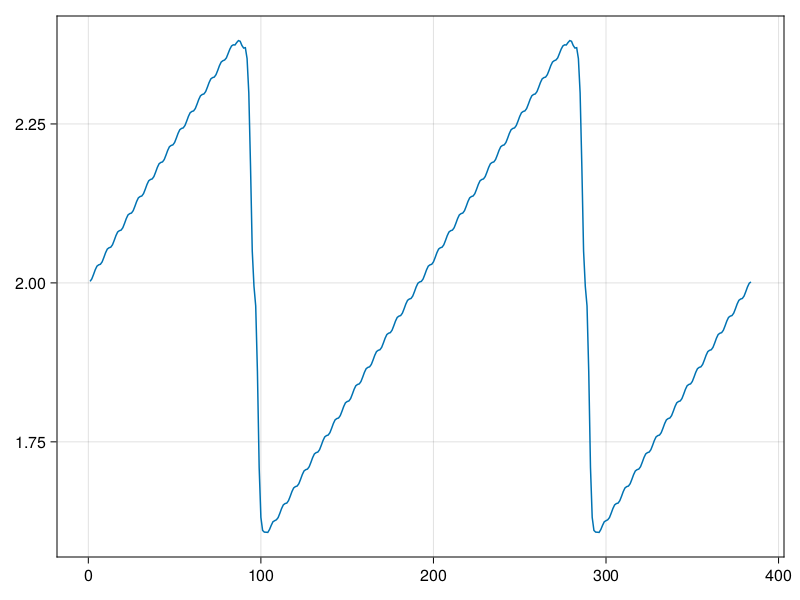

In [90]:
lines(sol(1.0))

In [91]:
heatmap(sol.t, xgrid, hcat(map(ti->sol(ti), sol.t)...)')

UndefVarError: UndefVarError: heatmap not defined

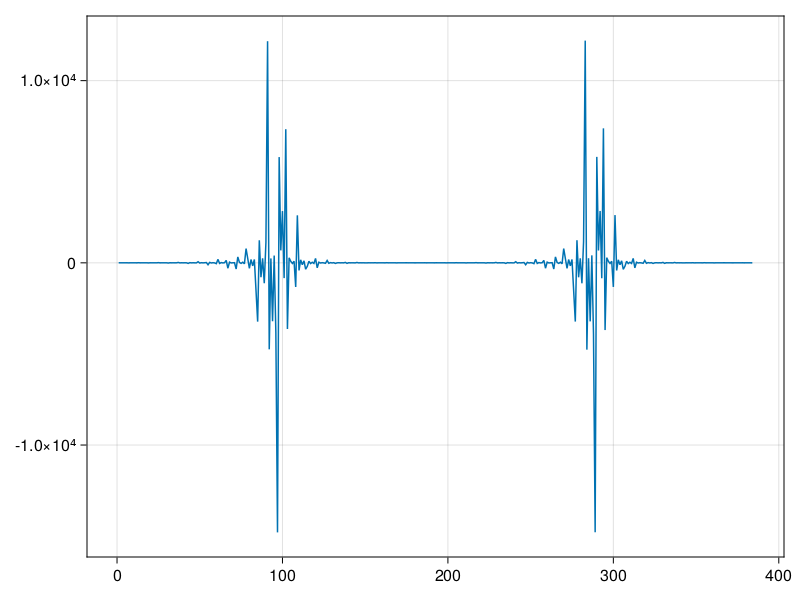

In [92]:
lines(sol(2.0))

In [93]:
# map(ui-> sum(ui), sol.u)